### Decoder is PDE solve of NN PDE

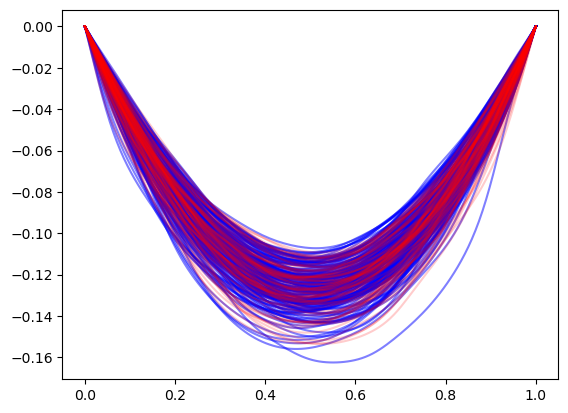

In [23]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional
import sys
import utils
import modules
sys.path.append('../../../research/learning_numerics')
# from time_integrators import newton_solve
import solve_pdes

datafile = 'data/ell0.1_d15_n2048_ksigma0.316.npz'
data = np.load(datafile)

x = torch.tensor(data['x'], dtype=torch.float32)
u_data = torch.tensor(data['u_sols'], dtype=torch.float32).T
n_total = u_data.shape[0]
n_train = 256
n_val = int(n_train * 0.3)
n_train = n_train - n_val
u_train = u_data[:n_train]
u_val = u_data[n_train:n_train+n_val]

plt.figure()
plt.plot(x, u_train.T, color='blue', alpha=0.5)
plt.plot(x, u_val.T, color='red', alpha=0.2)
None

In [31]:
torch.manual_seed(1)

n_samples = u_data.shape[0]
n_x = u_data.shape[1]
n_batch = min(100, n_samples)
u_batch = u_data[:n_batch]

latent_dim = 4
# latent_dim = 2
z = torch.randn(n_batch, latent_dim)

# _ = torch.randn(200) # mess with this to change NN initialization

# THE NN INITIALIZATION IS THE ISSUE!
omega_0 = 1.0
in_features = 4 + latent_dim
hidden_features = 10
hidden_layers = 2
out_features = 1

stab_term = 0e0

def get_N():
    return modules.Siren(in_features=in_features, hidden_features=hidden_features, hidden_layers=hidden_layers,
                         out_features=out_features, outermost_linear=True, first_omega_0=omega_0,
                         hidden_omega_0=omega_0)

full_model = modules.SolutionOfPDENet(get_N, x, latent_dim, init_kwaargs={'max_iter': 10, 'n_batch': 200})

u_solve_batch = torch.zeros(n_batch, n_x-2)
with torch.no_grad():
    u_solve_batch = full_model(u_solve_batch, z)
# for i in range(min(n_batch,10)):
#     plt.figure()
#     plt.plot(x[1:-1], u_solve_batch[i], label=f'Solved {i}', color=f'C{i}', linestyle=':', alpha=0.5)
#     plt.title(f'Initial Solve {i}')

Epoch 0, Loss 0.0031569984275847673
Epoch 50, Loss 0.001063272706232965
Epoch 100, Loss 0.0005072692292742431
Epoch 150, Loss 0.00029674152028746903
Epoch 200, Loss 0.00020983139984309673
Epoch 250, Loss 0.00017153065709862858
Epoch 300, Loss 0.0001533711765659973
Epoch 350, Loss 0.00014392002776730806
Epoch 400, Loss 0.00013840009341947734
Epoch 450, Loss 0.000134744041133672
Epoch 500, Loss 0.00013202516129240394
Epoch 550, Loss 0.00012981329928152263
Epoch 600, Loss 0.00012789925676770508
Epoch 650, Loss 0.00012617785250768065
Epoch 700, Loss 0.00012459425488486886
Epoch 750, Loss 0.00012311694445088506
Epoch 800, Loss 0.00012172620336059481
Epoch 850, Loss 0.00012041105219395831
Epoch 900, Loss 0.00011916306539205834
Epoch 950, Loss 0.00011797530169133097
Epoch 999, Loss 0.00011686442303471267


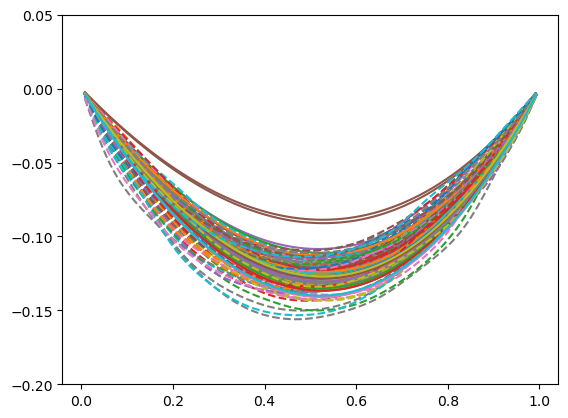

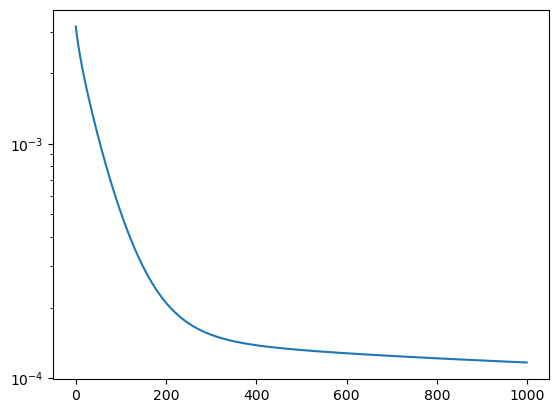

In [32]:

epochs = 1000
lr = 1e-2
losses = np.zeros(epochs)
optimizer = torch.optim.SGD(full_model.parameters(), lr=lr)

for epoch in range(epochs):
    print_update = epochs < 20 or epoch % (epochs // 20) == 0 or epoch == epochs - 1
    optimizer.zero_grad()
    u_solve_batch = full_model(u_solve_batch, z)
    loss = torch.mean((u_solve_batch - u_batch[:,1:-1])**2)
    loss.backward()
    optimizer.step()
    losses[epoch] = loss.item()
    # check nan
    if losses[epoch] == float('inf') or torch.isnan(loss) or losses[epoch] > 1e4 * losses[0]:
        print('Loss diverged. Exiting.')
        break
    u_solve_batch = u_solve_batch.detach()
    if print_update:
        print(f'Epoch {epoch}, Loss {loss.item()}')
        # reset optimizer momentum and other
        # optimizer = torch.optim.Adam(N_model.parameters(), lr=lr)

plt.figure()
for i in range(n_batch):
    u_solve_int = u_solve_batch[i]
    u_true = u_batch[i,1:-1]
    plt.plot(x[1:-1], u_solve_int, label=f'Final Solved {i}', color=f'C{i}', linestyle='-')
    plt.plot(x[1:-1], u_true, label=f'True {i}', color=f'C{i}', linestyle='--')

plt.ylim(-0.2, 0.05)
# plt.plot(x[1:-1], u_solve_int.de1tach(), label='Final Solved')
# plt.legend()

plt.figure()
plt.semilogy(losses)

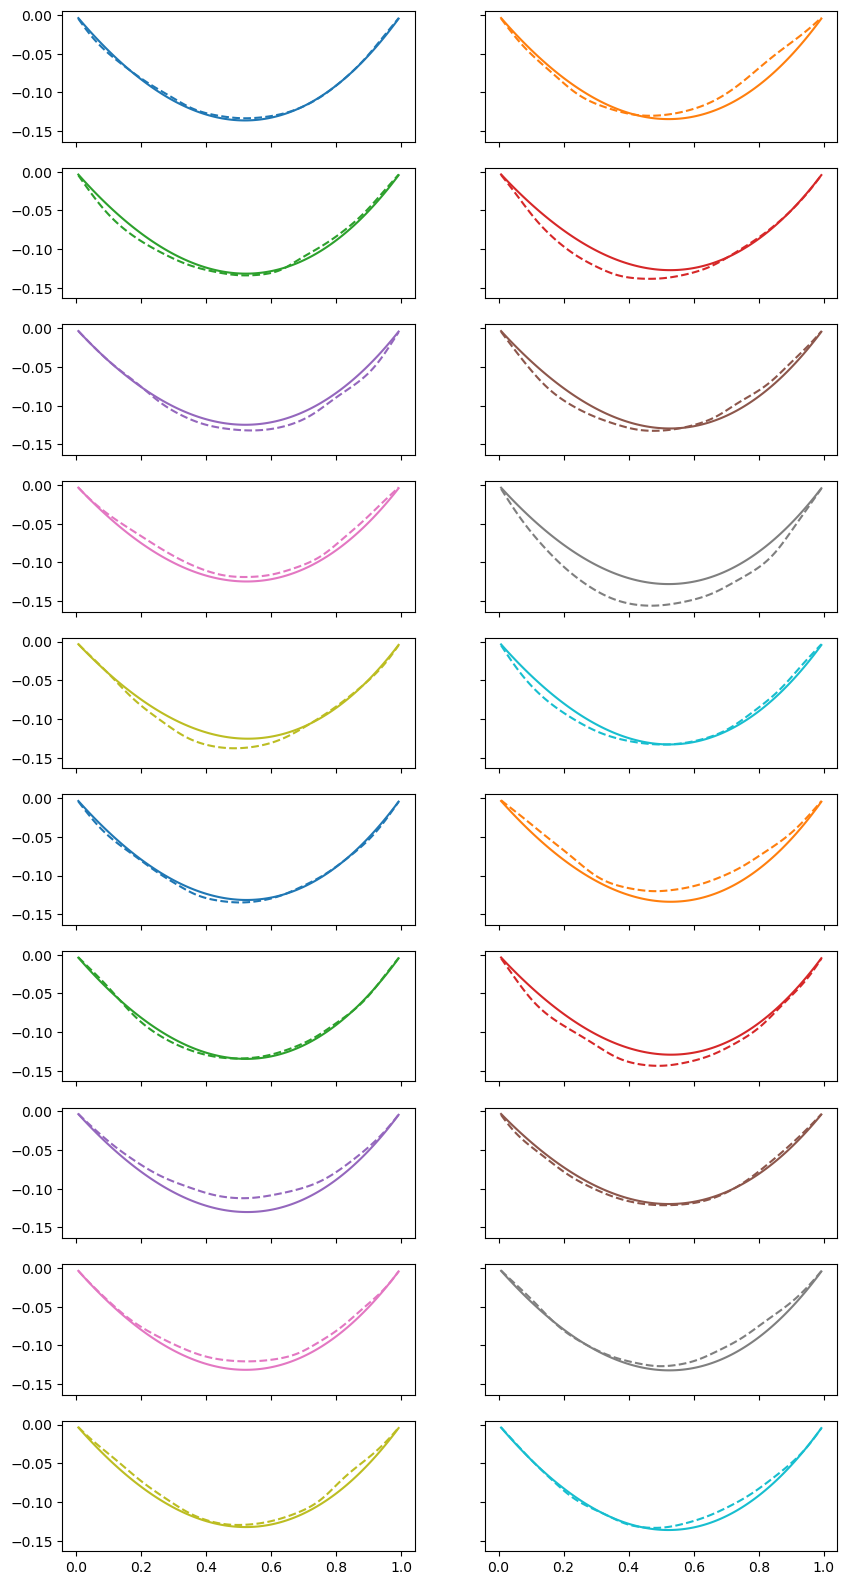

In [33]:
# just plot the above again, but split into subplots of 2 each
max_subplots = min(20, n_batch)
fig, axs = plt.subplots(max_subplots//2, 2, figsize=(10, 20), sharex=True, sharey=True)
for i in range(max_subplots):
    ax = axs[i // 2, i % 2]
    ax.plot(x[1:-1], u_solve_batch[i], label=f'Final Solved {i}', color=f'C{i}', linestyle='-')
    ax.plot(x[1:-1], u_batch[i,1:-1], label=f'True {i}', color=f'C{i}', linestyle='--')

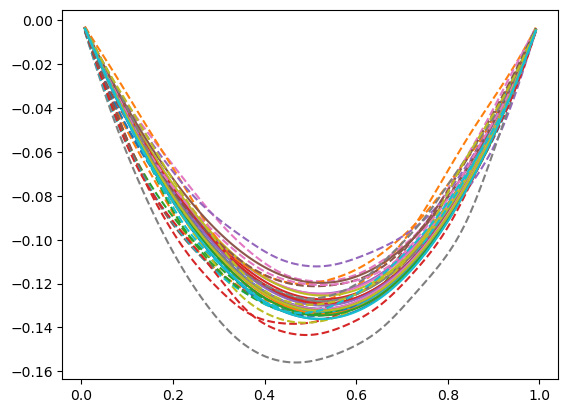

In [34]:
plt.figure()
for i in range(max_subplots):
    u_solve_int = u_solve_batch[i]
    u_true = u_batch[i,1:-1]
    plt.plot(x[1:-1], u_solve_int, label=f'Final Solved {i}', color=f'C{i}', linestyle='-')
    plt.plot(x[1:-1], u_true, label=f'True {i}', color=f'C{i}', linestyle='--')

In [16]:
for n, p in full_model.named_parameters():
    print(n, p)

N.net.0.linear.weight Parameter containing:
tensor([[-0.0837,  0.0445, -0.0472, -0.0671, -0.0172, -0.0407,  0.0746, -0.0254],
        [ 0.1087,  0.0299, -0.0194, -0.0855, -0.1048, -0.0314, -0.1091, -0.0236],
        [-0.0072, -0.0088, -0.0613,  0.0937,  0.0631, -0.0362, -0.0531,  0.0803],
        [ 0.1282, -0.1124, -0.0272, -0.0317, -0.0330,  0.1161, -0.0081,  0.1039],
        [-0.0198, -0.0156, -0.0727, -0.0210,  0.0267,  0.0473, -0.0137,  0.1240],
        [-0.0870,  0.0481,  0.1126, -0.0239,  0.0981,  0.0015, -0.0924, -0.0696],
        [ 0.0290, -0.0557,  0.0305,  0.1386,  0.0305, -0.0171,  0.0244, -0.0712],
        [-0.1176, -0.0949, -0.1048,  0.0345,  0.0140, -0.0613, -0.1267,  0.0692],
        [-0.0553, -0.0195, -0.1052, -0.0838,  0.0628, -0.1117, -0.0656,  0.0952],
        [-0.0729, -0.0531, -0.0352,  0.0638, -0.0872,  0.0082,  0.0457, -0.0061]],
       requires_grad=True)
N.net.0.linear.bias Parameter containing:
tensor([ 0.1759,  0.2159, -0.3288, -0.1571,  0.1712, -0.0747, -0.3

### Learnings
* It seems like the N model is extremely sensitive to its initialization, which aligns with my other work. I.e. just changing the random seed changes between success and `nan`s, with very little in between.
* This problem existed for both my custom architecture and SIREN's implementation.
* I briefly tried with `tanh` activation, but even the first Newton didn't converge, let alone the loss update to parameters. This is likely due to the gradient wrt the input being non-expressive / worse than `sin`.
* Changing any of the other parameters doesn't seem to help -- the only parameters that matter impact the *instance* of the NN initialization in some way. Thus, the number of samples doesn't usually impact the success *directly*, but by changing the random seed status, it does impact the success indirectly.
* Convergence on the first set of Newton solves (before training) is a very good indicator of success as opposed to `nan`s. At this point, I am confident this is just an indication of a good initialization of the neural network, rather than a good solution guess *causing* success (but the good guess might be helpful for later / faster convergence).

### Next Steps / Ideas to Try
* Might be a little premature for the VAE, before getting this sorted out (it would just be annoying), but I also don't know how long this problem will take.
* Try to modify the N model to be biased towards stability. This could be by scaling the u vs u_x vs u_xx terms, or adding on a base term which I know is stable.
* Revisit the SIREN paper, particularly the initialization.
* Also check out Invertible Neural Networks, and see what they do for stability (gradient clipping?). Maybe it's a relevant technique here, as it's the backward pass that's causing the issue.

